In [1]:
!pip install open-clip-torch torchvision faiss-cpu pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44

In [3]:
import kagglehub
import shutil

# Download latest version
path = kagglehub.dataset_download("aladdinpersson/flickr8kimagescaptions")

print("Path to dataset files:", path)
local_path = '/content/flickr8k_data'
shutil.copytree(path, local_path, dirs_exist_ok=True)

print("✅ Dataset is now in your working directory:", local_path)


100%|██████████| 1.04G/1.04G [00:48<00:00, 23.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/aladdinpersson/flickr8kimagescaptions/versions/1


In [14]:
import os
import torch
import open_clip
from PIL import Image
import numpy as np
from torchvision import transforms
import faiss
import pickle

# ---------- CONFIG ----------
IMAGE_FOLDER = "/content/flickr8k_data/flickr8k/images"
INDEX_FILE = "index.faiss"
ID_TO_PATH_FILE = "id_to_path.pkl"
TOP_K = 5

# ---------- MODEL SETUP ----------
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess, tokenizer = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
model = model.to(device)
tokenizer = open_clip.get_tokenizer('ViT-B-32')

# ---------- FUNCTIONS ----------
def get_image_embedding(image_path):
    image = Image.open(image_path).convert("RGB")
    image_tensor = preprocess(image).unsqueeze(0).to(device)
    with torch.no_grad():
        embedding = model.encode_image(image_tensor).cpu().numpy()
    return embedding[0]  # flatten to 1D

def get_text_embedding(text):
    tokens = tokenizer([text]).to(device)
    with torch.no_grad():
        embedding = model.encode_text(tokens).cpu().numpy()
    return embedding.astype('float32')

def build_faiss_index(image_folder):
    print("Building FAISS index from images...")
    embeddings = []
    id_to_path = {}
    for idx, file in enumerate(os.listdir(image_folder)):
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            path = os.path.join(image_folder, file)
            embedding = get_image_embedding(path)
            embeddings.append(embedding)
            id_to_path[idx] = path
            print(f"Processed {file}   index = {idx}")
    embeddings = np.array(embeddings).astype('float32')

    dim = embeddings.shape[1]
    index = faiss.IndexFlatL2(dim)
    index.add(embeddings)
    faiss.write_index(index, INDEX_FILE)

    with open(ID_TO_PATH_FILE, 'wb') as f:
        pickle.dump(id_to_path, f)

    print("Indexing complete. Saved index and mapping.")
    return index, id_to_path

def load_faiss_index():
    index = faiss.read_index(INDEX_FILE)
    with open(ID_TO_PATH_FILE, 'rb') as f:
        id_to_path = pickle.load(f)
    return index, id_to_path

def recommend_images(query, index, id_to_path, top_k=TOP_K):
    text_emb = get_text_embedding(query)
    D, I = index.search(text_emb, top_k)
    results = [(id_to_path[i], D[0][idx]) for idx, i in enumerate(I[0])]
    return results

# ---------- MAIN ----------
# Build index if not exists
if not os.path.exists(INDEX_FILE):
    index, id_to_path = build_faiss_index(IMAGE_FOLDER)
else:
    print("Loading existing index...")
    index, id_to_path = load_faiss_index()


Loading existing index...



Enter a description (or 'exit'): a bike

Top matches:
→ /content/flickr8k_data/flickr8k/images/3353400143_8b9543f7dc.jpg (Distance: 134.9060)
Saved: /content/output_matches/match_1.jpg


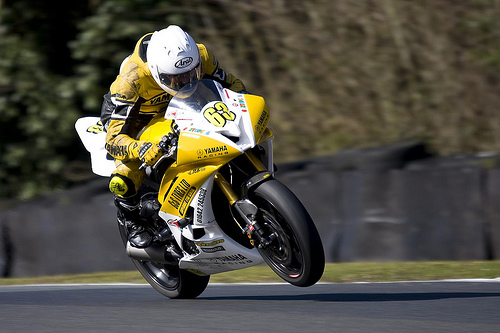

→ /content/flickr8k_data/flickr8k/images/3601843201_4809e66909.jpg (Distance: 135.6344)
Saved: /content/output_matches/match_2.jpg


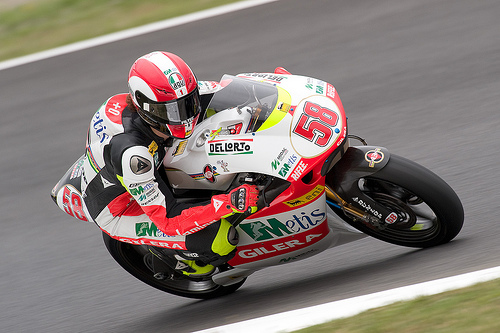

In [17]:
## Input and use

import os
from PIL import Image
from IPython.display import display

# Ensure output folder exists
output_dir = "/content/output_matches"
os.makedirs(output_dir, exist_ok=True)

query = input("\nEnter a description (or 'exit'): ")
results = recommend_images(query, index, id_to_path, 2)

print("\nTop matches:")
for i, (path, dist) in enumerate(results):
    print(f"→ {path} (Distance: {dist:.4f})")

    try:
        img = Image.open(path)
        filename = os.path.join(output_dir, f"match_{i+1}.jpg")
        img.save(filename)
        print(f"Saved: {filename}")
        display(img)
    except Exception as e:
        print(f"Failed to save/display image at {path} — {e}")
